<a href="https://colab.research.google.com/github/galdir/Vibration_classification_dataset_Wonho_Jung/blob/main/Vibration_classification_dataset_Wonho_Jung.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Dataset source

Dataset from https://data.mendeley.com/datasets/ztmf3m7h5x


# Config

In [16]:
import pandas as pd
import numpy as np
import tensorflow as tf
import scipy as sc
import zipfile
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import gc  

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.metrics import confusion_matrix

from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler


import scipy.io

from scipy import integrate
from scipy.signal import butter,filtfilt
from sklearn.utils import class_weight

import math
import pdb

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold






In [2]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
dataset_path = '/content/drive/MyDrive/datasets/vibration fault diagnosis of rotating machine - Wonho Jung/vibration.zip'
model_path = '/content/drive/MyDrive/Vibration classification - dataset Wonho Jung/models'

# zip file handler  
zip_handler = zipfile.ZipFile(dataset_path)

# list available files in the container
print (zip_handler.namelist())

['0Nm_BPFI_03.mat', '0Nm_BPFI_10.mat', '0Nm_BPFI_30.mat', '0Nm_BPFO_03.mat', '0Nm_BPFO_10.mat', '0Nm_BPFO_30.mat', '0Nm_Misalign_01.mat', '0Nm_Misalign_03.mat', '0Nm_Misalign_05.mat', '0Nm_Normal.mat', '0Nm_Unbalance_0583mg.mat', '0Nm_Unbalance_1169mg.mat', '0Nm_Unbalance_1751mg.mat', '0Nm_Unbalance_2239mg.mat', '0Nm_Unbalance_3318mg.mat', '2Nm_BPFI_03.mat', '2Nm_BPFI_10.mat', '2Nm_BPFI_30.mat', '2Nm_BPFO_03.mat', '2Nm_BPFO_10.mat', '2Nm_BPFO_30.mat', '2Nm_Misalign_01.mat', '2Nm_Misalign_03.mat', '2Nm_Misalign_05.mat', '2Nm_Normal.mat', '2Nm_Unbalalnce_0583mg.mat', '2Nm_Unbalalnce_1169mg.mat', '2Nm_Unbalalnce_1751mg.mat', '2Nm_Unbalalnce_2239mg.mat', '2Nm_Unbalalnce_3318mg.mat', '4Nm_BPFI_03.mat', '4Nm_BPFI_10.mat', '4Nm_BPFI_30.mat', '4Nm_BPFO_03.mat', '4Nm_BPFO_10.mat', '4Nm_BPFO_30.mat', '4Nm_Misalign_01.mat', '4Nm_Misalign_03.mat', '4Nm_Misalign_05.mat', '4Nm_Normal.mat', '4Nm_Unbalance_0583mg.mat', '4Nm_Unbalance_1169mg.mat', '4Nm_Unbalance_1751mg.mat', '4Nm_Unbalance_2239mg.mat',

In [4]:
files = zip_handler.namelist()

In [5]:
len(files)

45

## Utility functions

In [6]:
def butter_lowpass_filter(data, cutoff, fs, order):
    nyq = 0.5 * fs  # Nyquist Frequency
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    y = filtfilt(b, a, data)
    return y

In [7]:
def acc_to_vel(data, fs):
  window_length = len(data)
  data = data - np.mean(data)
  time_length = (window_length)/fs
  time = np.linspace(0, time_length, int(fs * time_length))
  signal_integrated = integrate.cumtrapz(data, x=time, initial=0.0)
  #signal_integrated = signal_integrated[fs:]
  # Filter requirements.
  #T = 5.0         # Sample Period
  #fs = 30.0       # sample rate, Hz
  cutoff = 10      # desired cutoff frequency of the filter, Hz ,      slightly higher than actual 1.2 Hz
  order = 2
  signal_integrated = butter_lowpass_filter(signal_integrated, cutoff, fs, order)
  return signal_integrated


In [8]:
def signalAmpSpectrum(signal, window_length, fs):
  """
  A function that returns the amplitude spectrum of a signal. 
  Use numpy's fft, removing the redundancy and multiplying the remaining energy by two, as the energy was divided by two in the spectral redundancy.

  Parameters:
    signal : array_like
      Input array
    window_length : int
      Number of points in the input to use. 
      Signal is reduced to the window_length.
    fs : int
      Sample frequency of the signal to calculate frequency array.  
  """
  
  #pdb.set_trace()
  signal = signal[:window_length]
  amps = np.abs(np.fft.rfft(signal))/window_length
  amps[0] = 0
  amps = amps * 2
  
  freqs = np.fft.rfftfreq(window_length, 1/fs)
  return [freqs, amps]

In [9]:
help(signalAmpSpectrum)

Help on function signalAmpSpectrum in module __main__:

signalAmpSpectrum(signal, window_length, fs)
    A function that returns the amplitude spectrum of a signal. 
    Use numpy's fft, removing the redundancy and multiplying the remaining energy by two, as the energy was divided by two in the spectral redundancy.
    
    Parameters:
      signal : array_like
        Input array
      window_length : int
        Number of points in the input to use. 
        Signal is reduced to the window_length.
      fs : int
        Sample frequency of the signal to calculate frequency array.



In [11]:
def plot_channels_time(experiment):
  print(data_names[experiment])

  window_length = len(data[experiment]['channel_1'])
  #data = data - np.mean(data)
  time_length = (window_length)/fs
  time = np.linspace(0, time_length, int(fs * time_length))

  fig = plt.figure(figsize=(12,8))
  ax1=plt.subplot(2,2,1)
  ax1.plot(time, data[experiment]['channel_1'])

  ax2=plt.subplot(2,2,2, sharey=ax1)
  ax2.plot(time, data[experiment]['channel_2'])

  ax3=plt.subplot(2,2,3, sharey=ax1)
  ax3.plot(time, data[experiment]['channel_3'])

  ax4=plt.subplot(2,2,4, sharey=ax1)
  ax4.plot(time, data[experiment]['channel_4'])

  plt.tight_layout()
  #fig.savefig("../figures/Fig.4_cd.png", dpi=200)
  plt.show()
  fig.clf()
  plt.close()
  gc.collect()


In [12]:
def plot_channels_spectra(experiment, y_lim=0, x_lim=600):
  print(data_names[experiment])
  fig = plt.figure(figsize=(12,8))
  ax1=plt.subplot(2,2,1)
  window_length = int(fs)
  starting_index = fs
  amp = np.abs(np.fft.rfft(data[experiment]['channel_1'].loc[starting_index : window_length + starting_index]))/window_length
  amp[0]=0
  amp=amp*2
  freq = np.fft.rfftfreq(window_length, d=1/fs)
  ax1.plot(freq, amp)
  amp_max = np.max(amp)

  #ax2=plt.subplot(2,2,2, sharey=ax1)
  ax2=plt.subplot(2, 2, 2)
  amp = np.abs(np.fft.rfft(data[experiment]['channel_2'].loc[starting_index : starting_index + window_length]))/window_length
  amp[0]=0 
  amp=amp*2
  freq = np.fft.rfftfreq(window_length, d=1/fs)
  ax2.plot(freq, amp)
  amp_max = max(np.max(amp), amp_max)

  #ax3=plt.subplot(2, 2, 3, sharey=ax1)
  ax3=plt.subplot(2, 2, 3)
  amp = np.abs(np.fft.rfft(data[experiment]['channel_3'].loc[starting_index : starting_index + window_length]))/window_length
  amp[0]=0 
  amp=amp*2
  freq = np.fft.rfftfreq(window_length, d=1/fs)
  ax3.plot(freq, amp)
  amp_max = max(np.max(amp), amp_max)

  #ax4=plt.subplot(2, 2, 4, sharey=ax1)
  ax4=plt.subplot(2, 2, 4)
  amp = np.abs(np.fft.rfft(data[experiment]['channel_4'].loc[starting_index : starting_index + window_length]))/window_length
  amp[0]=0 
  amp=amp*2
  freq = np.fft.rfftfreq(window_length, d=1/fs)
  ax4.plot(freq, amp)
  if y_lim == 0:
    amp_max = max(np.max(amp), amp_max*1.1)
  else:
    amp_max = y_lim
  
  print(amp_max)
  ax1.set_ylim((0, amp_max))
  ax2.set_ylim((0, amp_max))
  ax3.set_ylim((0, amp_max))
  ax4.set_ylim((0, amp_max))
  ax1.set_xlim((0, x_lim))
  ax2.set_xlim((0, x_lim))
  ax3.set_xlim((0, x_lim))
  ax4.set_xlim((0, x_lim))


  plt.tight_layout()
  #fig.savefig("../figures/Fig.4_cd.png", dpi=200)
  plt.show()
  fig.clf()
  plt.close()
  gc.collect()

# Classification of umbalance, misaligment and bearing faults

## Loading

In [18]:
fs=25600
new_fs = 4096
def mat_dataset_to_df(mat):
  datadf = [item.flat[0] for item in mat['Signal'][0][0]['y_values']['values']]
  a = datadf[0][:,0]
  #print(len(a))
  b = datadf[0][:,1]
  c = datadf[0][:,2]
  d = datadf[0][:,3]
  secs = len(a)/fs # Number of seconds in signal X
  samps = int(secs * new_fs)     # Number of samples to downsample
  a = scipy.signal.resample(a, samps)
  #print(len(a))
  b = scipy.signal.resample(b, samps)
  c = scipy.signal.resample(c, samps)
  d = scipy.signal.resample(d, samps)

  #a = acc_to_vel(a, new_fs)
  #b = acc_to_vel(b, new_fs)
  #c = acc_to_vel(c, new_fs)
  #d = acc_to_vel(d, new_fs)

  #print(len(datadf))
  columns = ['channel_1', 'channel_2', 'channel_3', 'channel_4' ]
  df = pd.DataFrame(list(zip(a, b, c, d)), columns=columns)  
  df.reset_index(inplace=True, drop=True)
  df.loc[:, 'channel_1']=acc_to_vel(df['channel_1'].values, new_fs)
  df.loc[:, 'channel_2']=acc_to_vel(df['channel_2'].values, new_fs)
  df.loc[:, 'channel_3']=acc_to_vel(df['channel_3'].values, new_fs)
  df.loc[:, 'channel_4']=acc_to_vel(df['channel_4'].values, new_fs)
  return df


data = []
data_names = []
with zipfile.ZipFile(dataset_path, 'r') as f:
  for i in range(len(files)):
    tokens = files[i].split('_')
    print(files[i])
    with f.open(files[i], 'r') as c:
        mat = scipy.io.loadmat(c)
        df = mat_dataset_to_df(mat)
        data.append(df)
        data_names.append(files[i])

0Nm_BPFI_03.mat
0Nm_BPFI_10.mat
0Nm_BPFI_30.mat
0Nm_BPFO_03.mat
0Nm_BPFO_10.mat
0Nm_BPFO_30.mat
0Nm_Misalign_01.mat
0Nm_Misalign_03.mat
0Nm_Misalign_05.mat
0Nm_Normal.mat
0Nm_Unbalance_0583mg.mat
0Nm_Unbalance_1169mg.mat
0Nm_Unbalance_1751mg.mat
0Nm_Unbalance_2239mg.mat
0Nm_Unbalance_3318mg.mat
2Nm_BPFI_03.mat
2Nm_BPFI_10.mat
2Nm_BPFI_30.mat
2Nm_BPFO_03.mat
2Nm_BPFO_10.mat
2Nm_BPFO_30.mat
2Nm_Misalign_01.mat
2Nm_Misalign_03.mat
2Nm_Misalign_05.mat
2Nm_Normal.mat
2Nm_Unbalalnce_0583mg.mat
2Nm_Unbalalnce_1169mg.mat
2Nm_Unbalalnce_1751mg.mat
2Nm_Unbalalnce_2239mg.mat
2Nm_Unbalalnce_3318mg.mat
4Nm_BPFI_03.mat
4Nm_BPFI_10.mat
4Nm_BPFI_30.mat
4Nm_BPFO_03.mat
4Nm_BPFO_10.mat
4Nm_BPFO_30.mat
4Nm_Misalign_01.mat
4Nm_Misalign_03.mat
4Nm_Misalign_05.mat
4Nm_Normal.mat
4Nm_Unbalance_0583mg.mat
4Nm_Unbalance_1169mg.mat
4Nm_Unbalance_1751mg.mat
4Nm_Unbalance_2239mg.mat
4Nm_Unbalance_3318mg.mat


In [19]:
fs=new_fs
speed = 3010 #rpm
amostras_por_rotacao = 1 / (speed / 60) * fs

In [20]:
experiment = 0

In [21]:
data_names[experiment]

'0Nm_BPFI_03.mat'

In [22]:
data[experiment]

,channel_1,channel_2,channel_3,channel_4
0,0.000135,0.000045,1.060265e-05,-6.644647e-05
1,-0.000355,0.000706,-5.057436e-05,1.199219e-05
2,-0.000365,0.000453,-5.450786e-07,-4.498358e-05
3,-0.000115,0.000286,8.273540e-05,-1.416822e-04
4,-0.000142,0.000642,-2.398845e-06,-3.416102e-05
...,...,...,...,...
245755,-0.000058,0.000021,2.676509e-04,1.370458e-05
245756,-0.000102,0.000316,2.717795e-04,2.020595e-04
245757,-0.000445,0.000297,2.661365e-04,2.173504e-04
245758,-0.000248,0.000074,2.411315e-04,-2.050478e-08


## EDA

0Nm_BPFI_03.mat


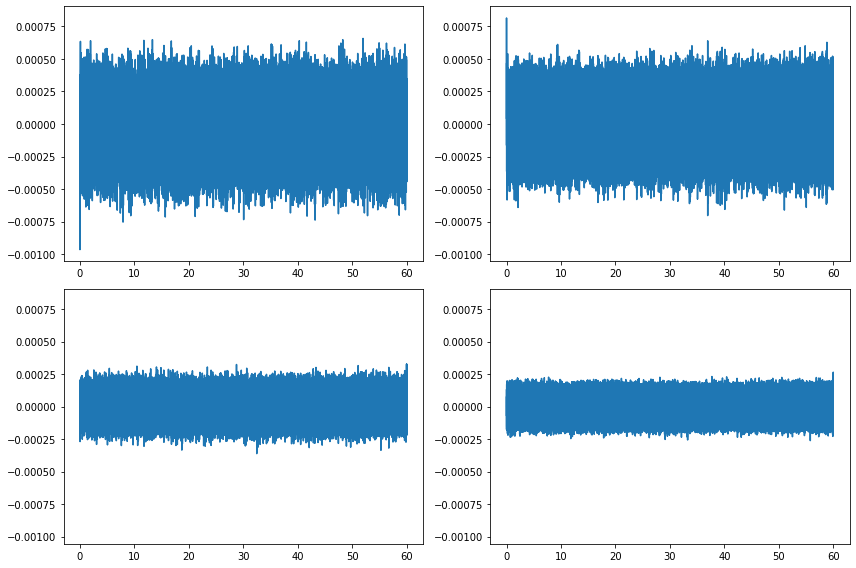

In [26]:
experiment = 0
plot_channels_time(experiment)

0Nm_BPFI_03.mat
0.0001


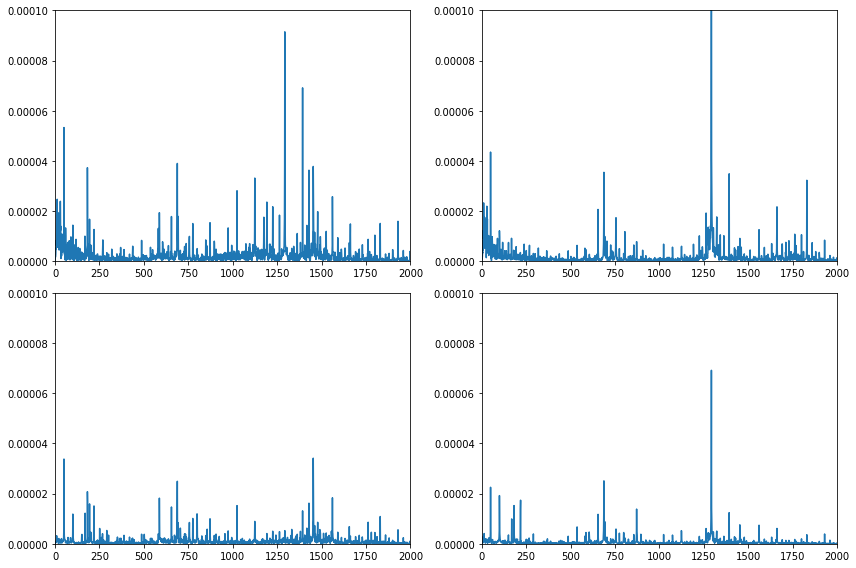

In [27]:
plot_channels_spectra(experiment, 0.0001, 2000)

0Nm_Misalign_01.mat
0.0001


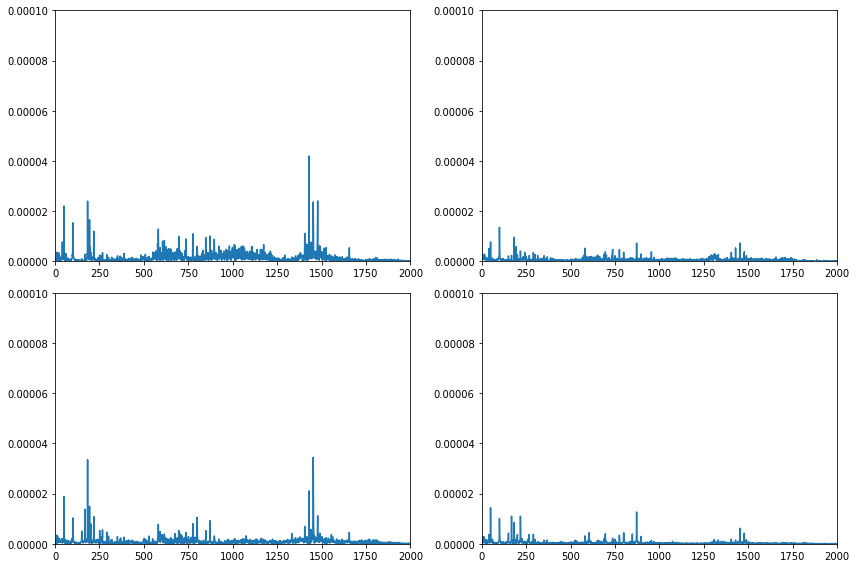

In [28]:
experiment = 6
plot_channels_spectra(experiment, 0.0001, 2000)

## Preprocessing

In [29]:
len(data_names)

45

In [30]:
data_names

['0Nm_BPFI_03.mat',
 '0Nm_BPFI_10.mat',
 '0Nm_BPFI_30.mat',
 '0Nm_BPFO_03.mat',
 '0Nm_BPFO_10.mat',
 '0Nm_BPFO_30.mat',
 '0Nm_Misalign_01.mat',
 '0Nm_Misalign_03.mat',
 '0Nm_Misalign_05.mat',
 '0Nm_Normal.mat',
 '0Nm_Unbalance_0583mg.mat',
 '0Nm_Unbalance_1169mg.mat',
 '0Nm_Unbalance_1751mg.mat',
 '0Nm_Unbalance_2239mg.mat',
 '0Nm_Unbalance_3318mg.mat',
 '2Nm_BPFI_03.mat',
 '2Nm_BPFI_10.mat',
 '2Nm_BPFI_30.mat',
 '2Nm_BPFO_03.mat',
 '2Nm_BPFO_10.mat',
 '2Nm_BPFO_30.mat',
 '2Nm_Misalign_01.mat',
 '2Nm_Misalign_03.mat',
 '2Nm_Misalign_05.mat',
 '2Nm_Normal.mat',
 '2Nm_Unbalalnce_0583mg.mat',
 '2Nm_Unbalalnce_1169mg.mat',
 '2Nm_Unbalalnce_1751mg.mat',
 '2Nm_Unbalalnce_2239mg.mat',
 '2Nm_Unbalalnce_3318mg.mat',
 '4Nm_BPFI_03.mat',
 '4Nm_BPFI_10.mat',
 '4Nm_BPFI_30.mat',
 '4Nm_BPFO_03.mat',
 '4Nm_BPFO_10.mat',
 '4Nm_BPFO_30.mat',
 '4Nm_Misalign_01.mat',
 '4Nm_Misalign_03.mat',
 '4Nm_Misalign_05.mat',
 '4Nm_Normal.mat',
 '4Nm_Unbalance_0583mg.mat',
 '4Nm_Unbalance_1169mg.mat',
 '4Nm_Unbalanc

In [31]:
labels = []
labels_dic = {'Misalign':2, 'Normal.mat': 0, 'Unbalance': 1, 'Unbalalnce': 1, 'BPFI': 3, 'BPFO': 4}

for name in data_names:
  tokens = name.split('_')
  print(tokens[1])
  labels.append(labels_dic.get(tokens[1], "No info available"))

print(f'Labels: {labels}')
print(len(labels))
  

BPFI
BPFI
BPFI
BPFO
BPFO
BPFO
Misalign
Misalign
Misalign
Normal.mat
Unbalance
Unbalance
Unbalance
Unbalance
Unbalance
BPFI
BPFI
BPFI
BPFO
BPFO
BPFO
Misalign
Misalign
Misalign
Normal.mat
Unbalalnce
Unbalalnce
Unbalalnce
Unbalalnce
Unbalalnce
BPFI
BPFI
BPFI
BPFO
BPFO
BPFO
Misalign
Misalign
Misalign
Normal.mat
Unbalance
Unbalance
Unbalance
Unbalance
Unbalance
Labels: [3, 3, 3, 4, 4, 4, 2, 2, 2, 0, 1, 1, 1, 1, 1, 3, 3, 3, 4, 4, 4, 2, 2, 2, 0, 1, 1, 1, 1, 1, 3, 3, 3, 4, 4, 4, 2, 2, 2, 0, 1, 1, 1, 1, 1]
45


In [32]:
fs

4096

In [33]:
print(labels.count(0)/len(labels))
print(labels.count(1)/len(labels))
print(labels.count(2)/len(labels))
print(labels.count(3)/len(labels))
print(labels.count(4)/len(labels))

0.06666666666666667
0.3333333333333333
0.2
0.2
0.2


In [45]:
def get_features(data, label, window):
    data = data[window:] # skip samples to avoid integration anomaly
    n = int(np.floor(len(data)/window))
    data = data[:int(n)*window]
    X = data.values.reshape((n, window))
    y = np.ones(n)*label
    return X, y




In [41]:
sensor = 'channel_1'
seconds_per_analysis = 1.0
window = int(fs * seconds_per_analysis)


X0,y0 = get_features(data[0][sensor], labels[0], window)
for i in range(1, len(data)):
  print(i)
  X1,y1 = get_features(data[i][sensor], labels[i], window)
  X0=np.concatenate([X0, X1])
  y0=np.concatenate([y0, y1])

X = X0
y = y0

print(X.shape, y.shape)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
(4455, 4096) (4455,)


In [42]:
sensor = 'channel_2'
seconds_per_analysis = 1.0
window = int(fs * seconds_per_analysis)


X0,y0 = get_features(data[0][sensor], labels[0], window)
for i in range(1, len(data)):
  print(i)
  X1,y1 = get_features(data[i][sensor], labels[i], window)
  X0=np.concatenate([X0, X1])

X2 = X0


print(X2.shape)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
(4455, 4096)


In [43]:
print(len(y[y==0])/len(y))
print(len(y[y==1])/len(y))
print(len(y[y==2])/len(y))
print(len(y[y==3])/len(y))
print(len(y[y==4])/len(y))

0.12053872053872054
0.4006734006734007
0.2404040404040404
0.1191919191919192
0.1191919191919192


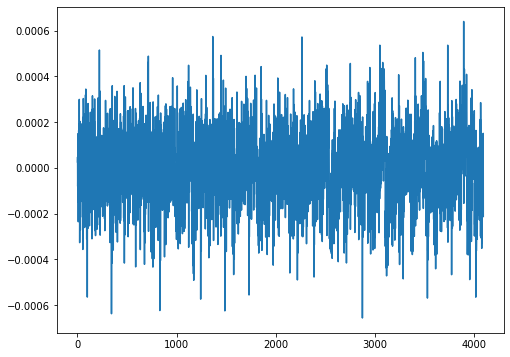

In [48]:
fig = plt.figure(figsize=(8,6))
plt.plot(X[0])

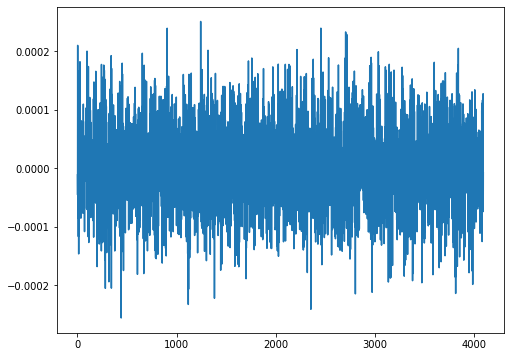

In [47]:
fig = plt.figure(figsize=(8,6))

plt.plot(X[1000])

## Split

In [49]:
train_test_ratio = 0.8
X_train, X_test, y_train, y_test, X2_train, X2_test = train_test_split(X, y, X2, test_size = 1-train_test_ratio, random_state = 42)

print(X.shape, y.shape, X2.shape)

print(X_train.shape, y_train.shape, X2_train.shape)


(4455, 4096) (4455,) (4455, 4096)
(3564, 4096) (3564,) (3564, 4096)


In [50]:
n_classes = 5

In [51]:
class_weights = class_weight.compute_class_weight(class_weight = 'balanced',
                                                 classes = np.unique(y_train),
                                                 y = y_train)

In [52]:
class_weights

array([1.63112128, 0.50841655, 0.81369863, 1.66542056, 1.69311164])

In [53]:
class_weights_dict = dict(enumerate(class_weights))

In [54]:
class_weights_dict

{0: 1.6311212814645308,
 1: 0.508416547788873,
 2: 0.8136986301369863,
 3: 1.6654205607476635,
 4: 1.6931116389548693}

## One Channel FFT

### Preprocessing

In [58]:

window = X_train.shape[1] 
X_train_prepared = np.abs(np.fft.rfft(X_train))/window
X_train_prepared[:, 0]=0 # to zero the zero frequency
X_train_prepared = X_train_prepared * 2 # rfft discards half spectrum, and half energy, so we can recover the energy this way
X_train_prepared = X_train_prepared[:, 0:600] # reducing spectrum to max 600Hz

#caler = MinMaxScaler()
#scaler.fit(X_train_prepared)
#X_train_scaled = scaler.transform(X_train_prepared)
#X_train_prepared = X_train_scaled

X_train_prepared = X_train_prepared * 10000 # to put values around 1




3.0


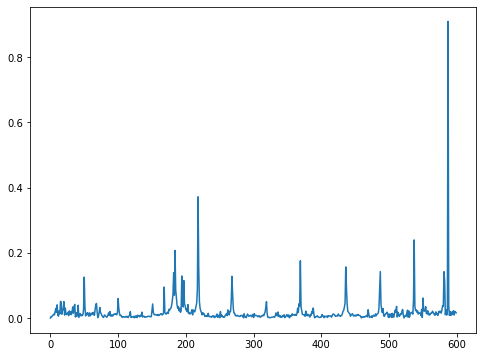

In [59]:
fig = plt.figure(figsize=(8,6))
plt.plot(X_train_prepared[0])
print(y_train[0])

1.0


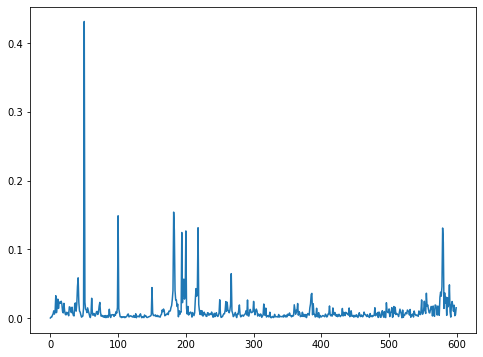

In [60]:
fig = plt.figure(figsize=(8,6))
plt.plot(X_train_prepared[6])
print(y_train[6])

### Training

In [61]:
def basicModel(X_train):
  kernel_size = 10
  filter_size = 32

  model = models.Sequential()
  model.add(layers.Conv1D(filters=filter_size, kernel_size=kernel_size, activation='relu', input_shape=(X_train.shape[1],1)))
  model.add(layers.MaxPooling1D(pool_size=2))
  model.add(layers.Conv1D(filter_size, (kernel_size), activation='relu'))
  model.add(layers.MaxPooling1D(pool_size=2))
  model.add(layers.Conv1D(filter_size, (kernel_size), activation='relu'))
  model.add(layers.MaxPooling1D(pool_size=2))
  model.add(layers.Flatten())
  model.add(layers.Dense(256, activation='relu'))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.Dense(n_classes, activation = 'softmax'))
  return model

In [62]:
model = basicModel(X_train_prepared)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 591, 32)           352       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 295, 32)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 286, 32)           10272     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 143, 32)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 134, 32)           10272     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 67, 32)           0

In [63]:
model.compile(optimizer='adam',
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [64]:
best_model_filepath = f"{model_path}/cnn_base_line_all_faults.h5"
checkpoint = ModelCheckpoint(best_model_filepath, monitor='val_accuracy', 
                                 verbose=1, save_best_only=True, mode='max')
earlystop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

In [65]:
n_epochs = 20
history = model.fit(X_train_prepared, y_train, epochs = n_epochs, batch_size = 64,
                   validation_split=0.33, callbacks=[checkpoint, earlystop],
                    class_weight=class_weights_dict)

Epoch 1/20
38/38 [==============================] - ETA: 0s - loss: 0.8152 - accuracy: 0.6891
Epoch 1: val_accuracy improved from -inf to 0.87935, saving model to /content/drive/MyDrive/Vibration classification of rotating shaft under unbalance/models/cnn_base_line_all_faults.h5
38/38 [==============================] - 9s 199ms/step - loss: 0.8152 - accuracy: 0.6891 - val_loss: 0.2015 - val_accuracy: 0.8794
Epoch 2/20
38/38 [==============================] - ETA: 0s - loss: 0.2244 - accuracy: 0.8944
Epoch 2: val_accuracy improved from 0.87935 to 0.95072, saving model to /content/drive/MyDrive/Vibration classification of rotating shaft under unbalance/models/cnn_base_line_all_faults.h5
38/38 [==============================] - 4s 114ms/step - loss: 0.2244 - accuracy: 0.8944 - val_loss: 0.1149 - val_accuracy: 0.9507
Epoch 3/20
37/38 [============================>.] - ETA: 0s - loss: 0.1157 - accuracy: 0.9531
Epoch 3: val_accuracy improved from 0.95072 to 0.95837, saving model to /content/

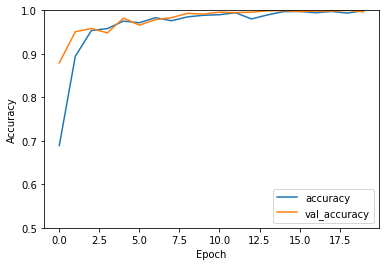

In [66]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

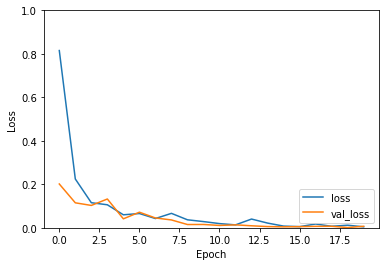

In [67]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1])
plt.legend(loc='lower right')

### evaluation

In [68]:
X_test_prepared = np.abs(np.fft.rfft(X_test))/window
X_test_prepared[:, 0]=0
X_test_prepared = X_test_prepared * 2
X_test_prepared = X_test_prepared[:, 0:600] # reducing to max 600Hz

#X_test_prepared = scaler.transform(X_test_prepared)

X_test_prepared = X_test_prepared * 10000


#X_test_prepared = np.reshape(X_test_prepared, (X_test_prepared.shape[0], X_test_prepared.shape[1], 1))

In [69]:
best_model = load_model(best_model_filepath)
best_model.evaluate(X_test_prepared, y_test)

28/28 [==============================] - 1s 14ms/step - loss: 0.0012 - accuracy: 1.0000


[0.0012194516602903605, 1.0]

In [70]:
y_pred = best_model.predict(X_test_prepared)


28/28 [==============================] - 1s 14ms/step


In [71]:
y_pred_classes = np.argmax(y_pred, axis=1)

confusion_matrix(y_test, y_pred_classes)



array([[100,   0,   0,   0,   0],
       [  0, 383,   0,   0,   0],
       [  0,   0, 195,   0,   0],
       [  0,   0,   0, 103,   0],
       [  0,   0,   0,   0, 110]])

In [72]:
prec = precision_score(y_test, y_pred_classes, average='macro' )
recall = recall_score(y_test, y_pred_classes, average='macro')
f1 = f1_score(y_test, y_pred_classes, average='macro')

print(f'Precision: {prec}') 
print(f'Recall: {recall}') 
print(f'F1-score: {f1}')

Precision: 1.0
Recall: 1.0
F1-score: 1.0
